# TIDY NOTEBOOK TO MAKE ALL FIGURES FOR PAPER

In [1]:
# Set up notebook

"""Import necessary packages"""

%load_ext autoreload
%autoreload 2

import os
from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import torch as t
import matplotlib.pyplot as plt

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
import seaborn as sns
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis.plot import plot_loss_across_sparsities, plot_input_output_response, plot_weight_bars
from toy_cis.util import threshold_matrix, in_out_response

"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 16})

"""Set torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# device = t.device("cpu")  # small toy models have lower loss and are faster via cpu
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA A40'


In [2]:
# Initialize models

"""ReLU + x model with Identity embedding"""
layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_noEmbed_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=False,
)
name = "ReluPlusX_NoEmbedding"


"""ReLU + x model with Random embedding"""
layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_embed_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=True,
    We_dim=1000
)
name = "ReluPlusX_WithEmbedding"

In [3]:
# Choose a model and train it 

"""Select the model configuration"""
model_cfg = reluPlusX_res_embed_cfg

"""Select the feature probability of the training input."""
feat_sparsity = 0.50

"""Other hyperparameters"""
batch_sz = 2048
feat_importance = 1
lr = 3e-3
n_steps = 10000
logging_freq = n_steps // 10

model = Cis(model_cfg, device=device, name=name )

losses = model.train_reluPlusX(
        batch_sz,
        feat_sparsity,
        feat_importance,
        n_steps,
        lr, 
        logging_freq, 
)
display(losses)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.09954135864973068,
 0.03594089299440384,
 0.03618931397795677,
 0.036376673728227615,
 0.03661505877971649,
 0.03625800460577011,
 0.036187708377838135,
 0.03574464097619057,
 0.0360880084335804,
 0.03603546321392059,
 0.036031078547239304]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

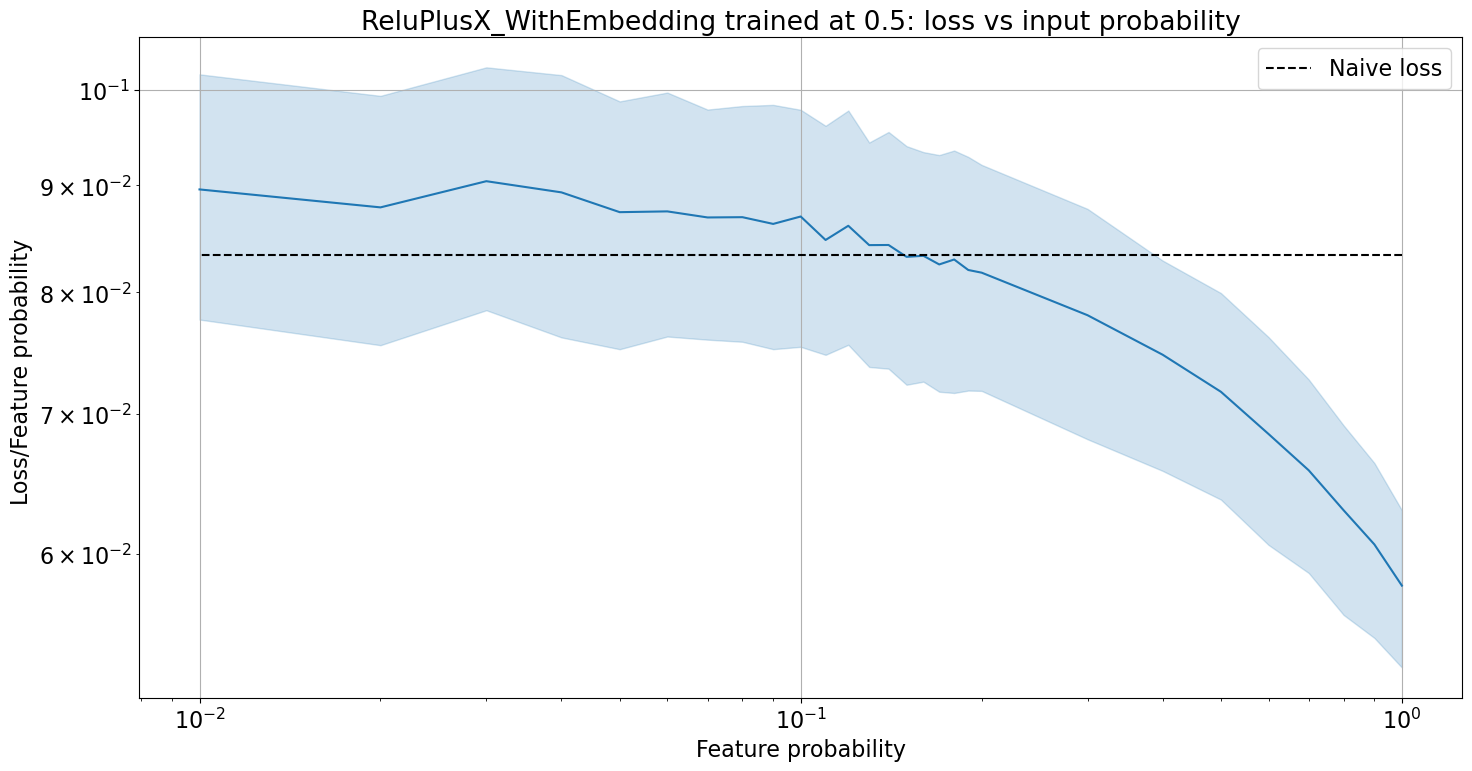

In [8]:
"""Compute and plot the model's performance across sparsities."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1
logging_freq = n_steps // 10

loss_data = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Testing over sparsities")
n_examples = 10000
loss_data = []
for s in pbar:
    
    with t.no_grad():
        # generate examples of inputs
        x, y_true = model.gen_batch_reluPlusX (n_examples, s)
        
        # compute mean loss
        y = model.forward(x)
        active_weight, inactive_weight = 10, 1
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        loss = weights * (y - y_true) ** 2
        
        # store loss at sparsity level
        loss = rearrange(loss, "examples 1 features -> examples features")
        loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
        for feat_idx, val in enumerate(loss):
            loss_data.append({"sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})

"""Plot performance across different input sparsities"""
fig = plot_loss_across_sparsities(loss_data, sparsities, model.name, feat_sparsity)

# save figure and show
feat_prob = 1 - feat_sparsity
filename = f"/workspace/{model.name}_S{feat_prob:.2f}_loss_plot.png" 
plt.savefig(filename, dpi=300)
plt.show()

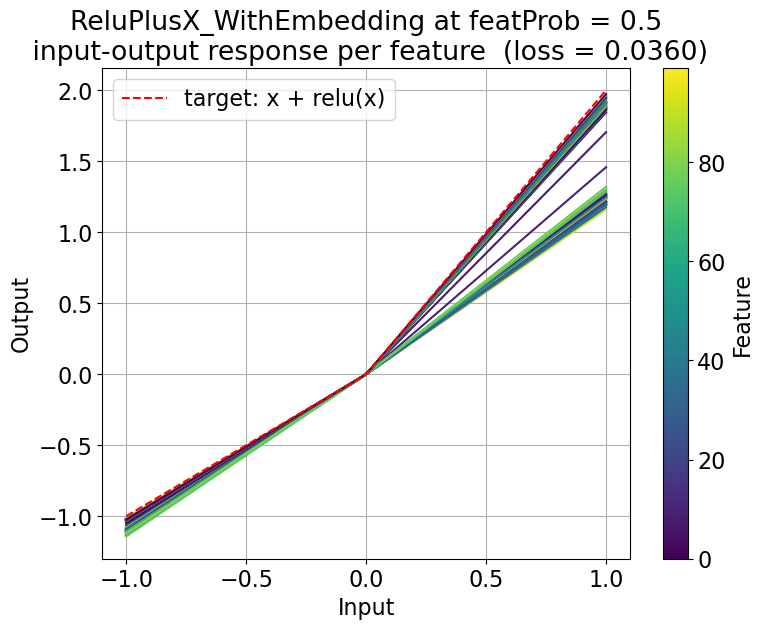

In [11]:
"""Compute and plot input-output response profile."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(model, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
plt.grid()
ax = fig.get_axes()[0]
ax.plot(
    asnumpy(vals), asnumpy(vals + t.relu(vals)), color="red", linestyle="--", label="target: x + relu(x)"
)
ax.set_title(
    f"{model.name} at featProb = {feat_prob}" 
    + f"\n input-output response per feature  (loss = {losses[-1]:.4f})"
)
ax.legend()

# save figure and show
filename = f"/workspace/{model.name}_S{feat_prob:.2f}_input_output_response.png" 
plt.savefig(filename, dpi=300)
plt.show()

W.shape=torch.Size([100, 50])


<function matplotlib.pyplot.show(close=None, block=None)>

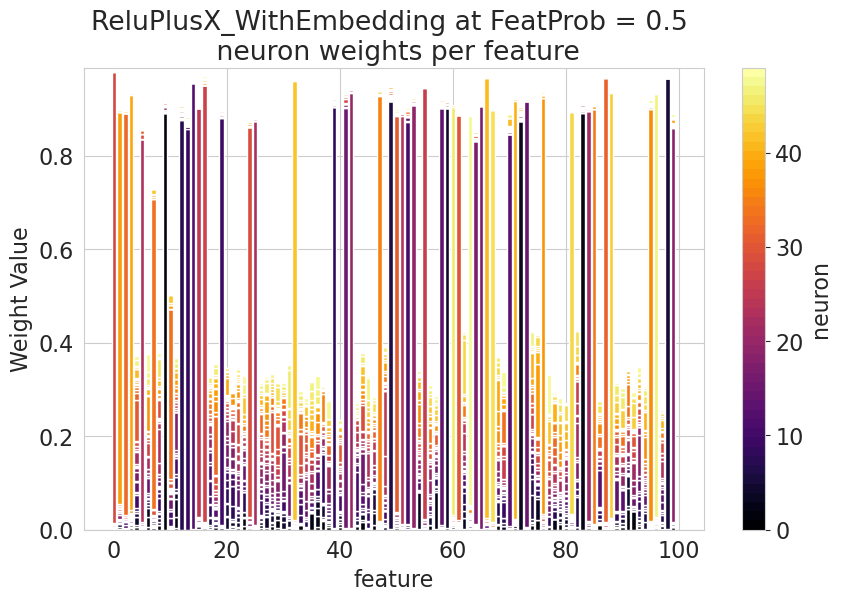

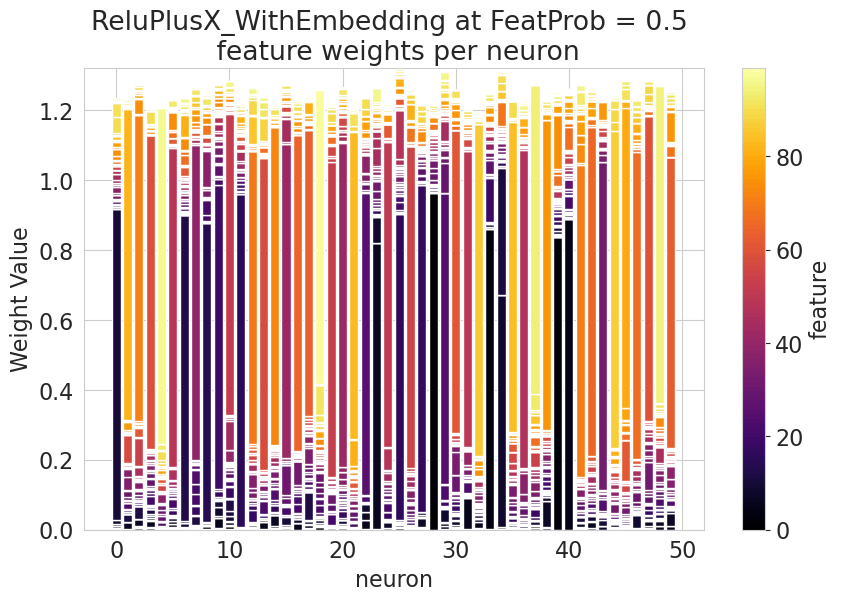

In [18]:
"""Extract and plot weights."""

if model.cfg.We_and_Wu == True: 
    W_feat_to_neuron = einsum(model.We, model.W1,
                          "inst emb feat, inst neuron emb -> neuron feat")
    W_neuron_to_feat = einsum(model.W2, model.Wu,
                          "inst emb neuron, inst feat emb -> feat neuron")
    W = einsum(W_feat_to_neuron, W_neuron_to_feat, "neuron feat, feat neuron -> feat neuron")
else:
    W = einsum(model.W1, model.W2, 
               "inst neuron feature, inst feature neuron-> neuron feature")
    
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W.T, xax="feature")
fig.get_axes()[0].set_title(f"{model.name} at FeatProb = {feat_prob} \n neuron weights per feature")
filename = f"/workspace/{model.name}_S{feat_prob:.2f}_weights_per_feature.png" 
plt.savefig(filename, dpi=300)
plt.show

fig = plot_weight_bars(W, xax="neuron")
fig.get_axes()[0].set_title(f"{model.name} at FeatProb = {feat_prob} \n feature weights per neuron")
filename = f"/workspace/{model.name}_S{feat_prob:.2f}_weights_per_neuron.png" 
plt.savefig(filename, dpi=300)
plt.show